This project uses articles from TechCrunch from 2010 to 2016 to conduct Natural Languages Processing analysis.

### Import the Packages and Data

In [36]:
import pandas as pd
import numpy as np
import random
import re
import nltk
import pickle
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import requests

%matplotlib inline

In [37]:
pd.options.display.max_columns = 100

### Import the data

In [38]:
raw = pd.read_csv('techcrunch_posts.csv')

In [39]:
# Drop the articles without contents

df = raw[pd.notnull(raw['content'])]

In [40]:
# Fill null values

df[['category']].fillna('none', inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39061 entries, 0 to 39114
Data columns (total 11 columns):
authors     38761 non-null object
category    38339 non-null object
content     39061 non-null object
date        39061 non-null object
id          39061 non-null int64
img_src     39061 non-null object
section     39061 non-null object
tags        34097 non-null object
title       39061 non-null object
topics      5590 non-null object
url         39061 non-null object
dtypes: int64(1), object(10)
memory usage: 3.6+ MB


In [42]:
df['category'].describe()

count     38339
unique       55
top        Apps
freq       9383
Name: category, dtype: object

### Exploratory Data Analysis

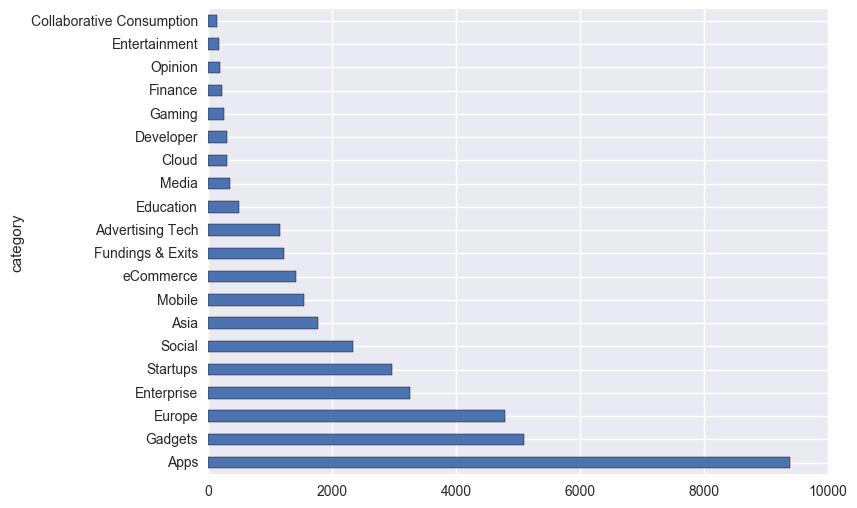

In [43]:
# Plot the categories

categories = df.groupby('category')['id'].count()
categories = categories.sort_values(ascending = False)[:20]

categories.plot(kind = 'barh', figsize=(8, 6))

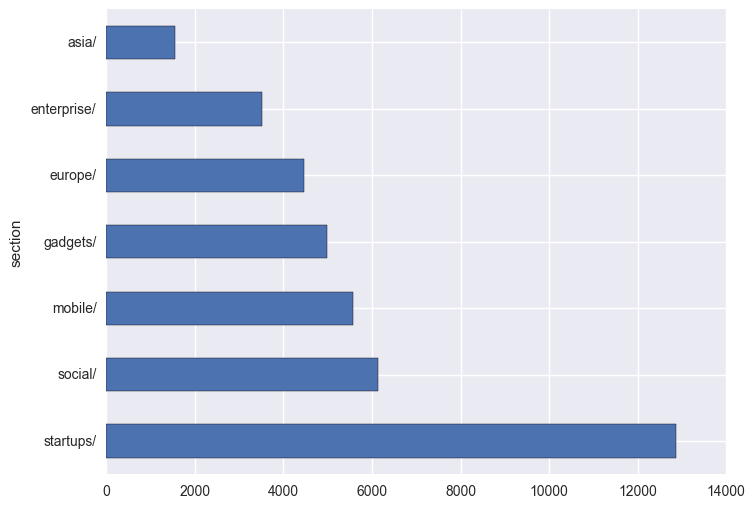

In [44]:
# Plot the sections

sections = df.groupby('section')['id'].count()
sections = sections.sort_values(ascending = False)[:20]

sections.plot(kind = 'barh', figsize=(8, 6))

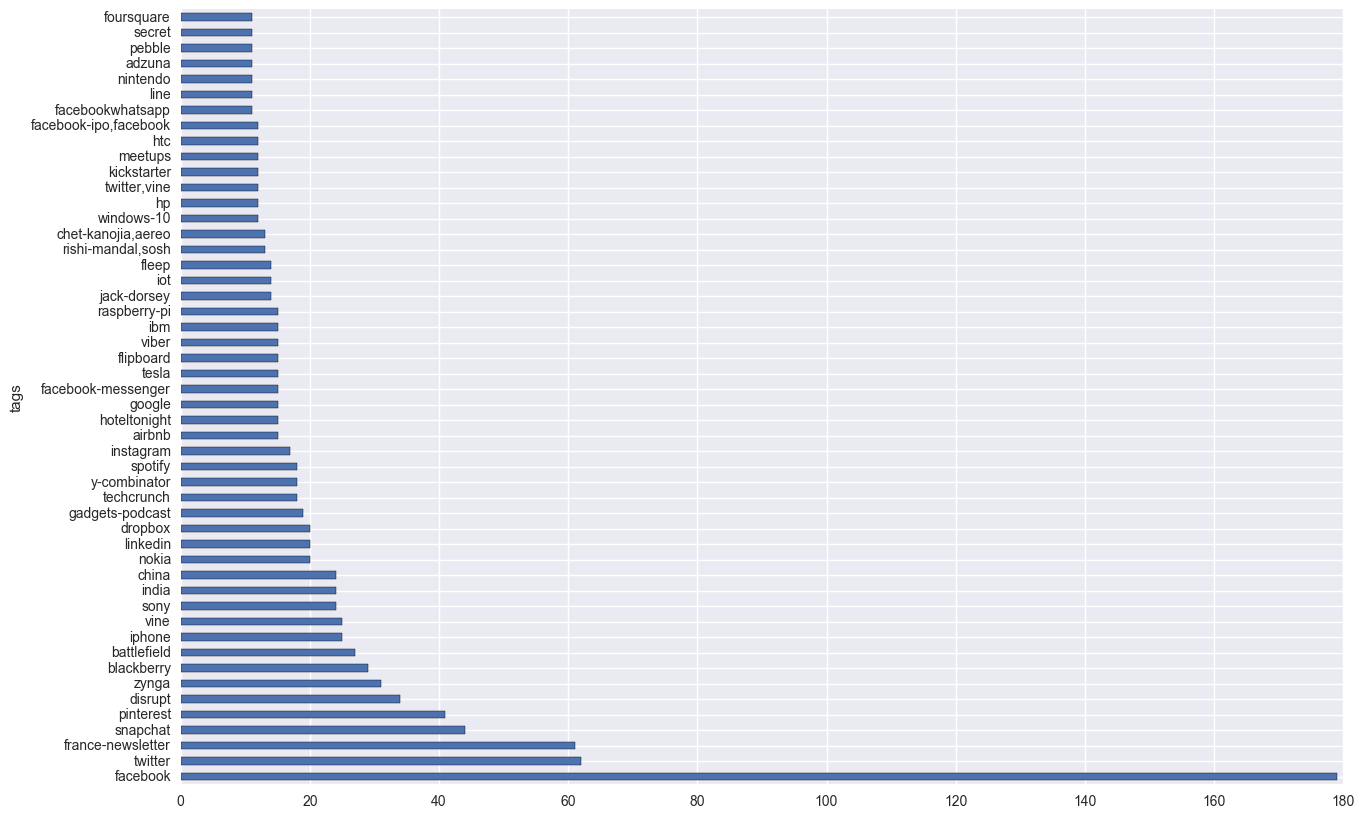

In [45]:
# Plot the tags

tags = df.groupby('tags')['id'].count()
tags = tags.sort_values(ascending = False)[:50]

tags.plot(kind = 'barh', figsize=(15, 10))

### Document Processing

In [46]:
# Create a list of tags with more than 10 documents

list_of_tags = []

for item in dict(tags[tags >= 10]).keys():
    list_of_tags.append(item)

In [47]:
len(list_of_tags)

50

There are 50 tags (aka topics) with more than 10 documents, such as facebook, twitter, techcruch, etc.

In [48]:
# Create a dataframe for only documents with top tags

def doc_with_tags(data, tags):
    dataframe = pd.DataFrame()
    for tag in tags:
        df_tag = df[df['tags'] == tag].sample(10)
        dataframe = dataframe.append(df_tag)
    return dataframe

In [49]:
df_tags = doc_with_tags(df, list_of_tags)

In [50]:
df_tags.head()

,authors,category,content,date,id,img_src,section,tags,title,topics,url
33000,Alex Wilhelm,Media,Sometimes move fast and break things ends with...,2014-02-03,951859,https://tctechcrunch2011.files.wordpress.com/2...,startups/,google,California State Agency Tells Google To Move I...,NaN,https://techcrunch.com/2014/02/03/california-s...
29743,Josh Constine,Social,There’s blood in the water surrounding Google ...,2012-01-11,481408,https://tctechcrunch2011.files.wordpress.com/2...,social/,google,Sharks Circle Around Google Search+: EPIC Crie...,NaN,https://techcrunch.com/2012/01/11/google-searc...
30487,Sarah Perez,Social,Google quietly added a trending topics section...,2011-11-18,454957,https://tctechcrunch2011.files.wordpress.com/2...,social/,google,"Like Twitter, Google+ Now Has Trending Topics",NaN,https://techcrunch.com/2011/11/18/like-twitter...
31215,MG Siegler,Social,"A week ago, we noted the talk amongst develope...",2011-09-15,422468,https://tctechcrunch2011.files.wordpress.com/2...,social/,google,Google+ Opens First APIs: Read-Only And No Cir...,NaN,https://techcrunch.com/2011/09/15/google-plus-...
27782,Matt Burns,Gadgets,"Using any mobile browser, type “let’s go carol...",2013-12-18,932035,https://tctechcrunch2011.files.wordpress.com/2...,mobile/,google,Turn Your Smartphone Into A Caroling Karaoke M...,NaN,https://techcrunch.com/2013/12/18/turn-your-sm...


In [51]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 33000 to 314
Data columns (total 11 columns):
authors     498 non-null object
category    495 non-null object
content     500 non-null object
date        500 non-null object
id          500 non-null int64
img_src     500 non-null object
section     500 non-null object
tags        500 non-null object
title       500 non-null object
topics      87 non-null object
url         500 non-null object
dtypes: int64(1), object(10)
memory usage: 46.9+ KB


I will use this dataframe 'df_tags' for the rest of the analysis.

#### WordCloud Showing the Tags

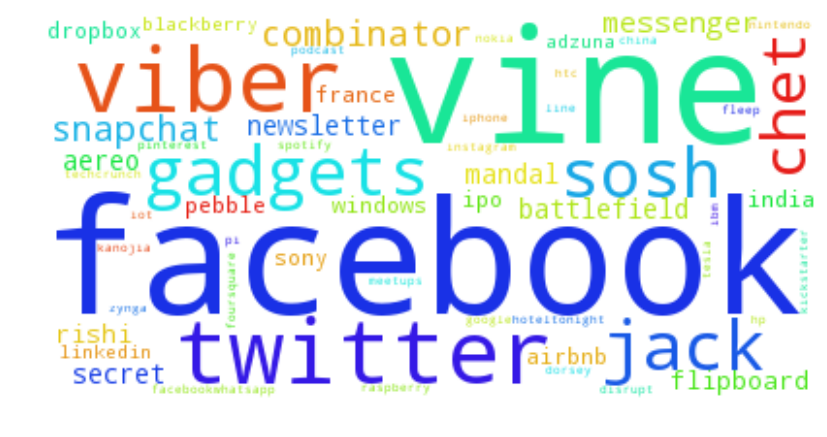

In [52]:
# Word Cloud for displaying tags (without word size weights)

list_of_tags_combined = ' '.join([str(t) for t in df_tags['tags']])
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white').generate(cloud_text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# wordcloud.to_file('wordcloud.png')

### Process the Article Content

##### Removing punctuation, convert words to lower case, remove stop words and stemming.

In [53]:
def process_content(data):
    
    # Keep only the words, remove punctuations
    formatted_content = re.sub("[^a-zA-Z]", " ", data)
    
    # Convert all words to lower case and split into a list
    words = formatted_content.lower().split()
    
    # List of stop words
    stop = stopwords.words('english')
    
    # Produce a list of clean words that does not appear in stop words
    clean_words = [w for w in words if w not in stop]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    stem_clean_words = [stemmer.stem(w) for w in clean_words if w not in stop]

    return " ".join(stem_clean_words)

In [54]:
# Create a list of clean contents for df_tags

def concat_tag_content(data, tag_list):
    total_list = []
    n = 0
    for tag in tag_list:
        print (str(n) + ' ' + tag)
        tags_clean_content = []
        sub_df = data[data['tags'] == tag]
        sub_list = []
        for article in sub_df['content']:
            sub_list.append(process_content(article))
        tags_clean_content.append(sub_list)
        words = [w for sublist in tags_clean_content for w in sublist]
        total_list.append(" ".join(words))
        n += 1
    return total_list

In [55]:
concat = concat_tag_content(df_tags, list_of_tags)

0 google
1 viber
2 snapchat
3 instagram
4 facebook
5 battlefield
6 windows-10
7 secret
8 vine
9 flipboard
10 facebook-messenger
11 dropbox
12 pebble
13 airbnb
14 hoteltonight
15 y-combinator
16 twitter
17 sony
18 india
19 facebook-ipo,facebook
20 blackberry
21 adzuna
22 linkedin
23 facebookwhatsapp
24 meetups
25 zynga
26 nokia
27 fleep
28 rishi-mandal,sosh
29 france-newsletter
30 pinterest
31 twitter,vine
32 foursquare
33 jack-dorsey
34 htc
35 techcrunch
36 gadgets-podcast
37 hp
38 disrupt
39 iot
40 iphone
41 kickstarter
42 ibm
43 tesla
44 nintendo
45 line
46 spotify
47 raspberry-pi
48 chet-kanojia,aereo
49 china


In [56]:
concat

['sometim move fast break thing end broken thing today news broke san francisco bay conserv develop commiss bcdc state agenc told googl must move infam mysteri barg compani appear lack proper author start construct accord ap larri goldzband bcdc execut director treasur island develop author tida could face fine enforc proceed allow project proceed googl spokesperson told techcrunch receiv letter san francisco bay conserv develop commiss review techcrunch reach bcdc tida comment ap stori googl barg becam focu intens specul eventu uncov would like sort high tech showroom googl toy cool hardli jame bond villian enough hold public attent barg find new home proper permit make public stage imag portland press herald blood water surround googl search call googl search plu world electron privaci inform center recommend ftc look search possibl privaci antitrust concern meanwhil twitter gener counsel alexand macgillivray provid appar damn evid search unfairli skew search result toward googl cont

In [57]:
len(concat)

50

In [58]:
# Store the list of concatenated articles for 50 tag words in variable 'contents'

contents = concat

### TD-IDF Matrix

In [ ]:
# TF-IDF Matrix for top 100 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.90, stop_words='english')
x_tfidf = tfidf.fit_transform(contents)

In [60]:
print('Matrix')
x_back_tfidf = x_tfidf.toarray()
print(x_back_tfidf)

Matrix
[[ 0.01957055  0.00665713  0.02408519 ...,  0.01157491  0.          0.06266281]
 [ 0.03983384  0.12194904  0.03676719 ...,  0.          0.57836882  0.        ]
 [ 0.01614299  0.09884173  0.04470063 ...,  0.07160774  0.          0.07753221]
 ..., 
 [ 0.0377659   0.          0.12200459 ...,  0.05025704  0.02611158
   0.03627671]
 [ 0.34538907  0.04146624  0.         ...,  0.          0.          0.01951586]
 [ 0.03849713  0.0785712   0.0355334  ...,  0.05123013  0.02661717
   0.11093732]]


In [61]:
TFIDF_df = pd.DataFrame(x_back_tfidf, columns=tfidf.get_feature_names())
TFIDF_df.index = list_of_tags
TFIDF_df = TFIDF_df.round(2)
TFIDF_df.head(10)

,access,activ,ad,alreadi,android,announc,app,appl,avail,base,becom,big,billion,bring,build,busi,ceo,chang,commun,connect,content,creat,current,custom,data,design,develop,devic,differ,end,event,expect,experi,facebook,feed,follow,founder,free,friend,fund,game,googl,growth,help,howev,instagram,know,let,line,mani,mean,messag,mobil,model,month,music,network,news,nokia,note,number,percent,person,phone,photo,plan,platform,point,post,price,project,provid,recent,report,revenu,right,said,sale,search,secret,share,sinc,smartphon,social,spotifi,start,startup,team,techcrunch,think,tri,twitter,updat,video,vine,want,watch,week,window,world
google,0.02,0.01,0.02,0.02,0.09,0.03,0.04,0.00,0.00,0.04,0.01,0.01,0.00,0.02,0.02,0.01,0.00,0.05,0.01,0.02,0.07,0.03,0.02,0.01,0.11,0.01,0.08,0.04,0.02,0.05,0.06,0.01,0.01,0.05,0.00,0.01,0.00,0.00,0.04,0.01,0.00,0.88,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.02,0.00,0.02,0.04,0.00,0.04,0.01,0.03,0.01,0.0,0.01,0.01,0.01,0.07,0.03,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.03,0.00,0.03,0.02,0.00,0.35,0.00,0.02,0.02,0.01,0.06,0.00,0.02,0.02,0.04,0.03,0.01,0.04,0.11,0.09,0.01,0.00,0.01,0.01,0.01,0.00,0.06
viber,0.04,0.12,0.04,0.00,0.15,0.02,0.34,0.00,0.09,0.05,0.02,0.00,0.14,0.05,0.00,0.12,0.17,0.00,0.06,0.07,0.00,0.04,0.09,0.00,0.00,0.08,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.14,0.00,0.00,0.00,0.00,0.05,0.03,0.00,0.00,0.04,0.16,0.00,0.04,0.05,0.25,0.18,0.05,0.21,0.00,0.00,0.00,0.0,0.04,0.07,0.02,0.00,0.22,0.10,0.04,0.16,0.00,0.00,0.11,0.00,0.04,0.11,0.00,0.18,0.00,0.03,0.00,0.14,0.00,0.04,0.00,0.05,0.00,0.00,0.10,0.04,0.00,0.02,0.00,0.00,0.00,0.15,0.05,0.00,0.00,0.00,0.00,0.58,0.00
snapchat,0.02,0.10,0.04,0.03,0.02,0.04,0.47,0.00,0.03,0.10,0.02,0.10,0.17,0.03,0.01,0.04,0.00,0.00,0.11,0.06,0.13,0.05,0.04,0.00,0.07,0.00,0.00,0.00,0.08,0.06,0.10,0.03,0.05,0.20,0.00,0.12,0.07,0.00,0.27,0.06,0.02,0.03,0.02,0.04,0.11,0.08,0.13,0.12,0.02,0.10,0.06,0.28,0.06,0.00,0.07,0.05,0.07,0.02,0.0,0.06,0.20,0.00,0.09,0.04,0.29,0.01,0.01,0.06,0.10,0.00,0.02,0.02,0.09,0.21,0.05,0.09,0.04,0.02,0.02,0.03,0.15,0.09,0.00,0.11,0.00,0.04,0.03,0.03,0.11,0.02,0.04,0.06,0.17,0.09,0.00,0.13,0.02,0.07,0.00,0.08
instagram,0.00,0.02,0.03,0.01,0.03,0.00,0.07,0.00,0.01,0.02,0.01,0.02,0.04,0.01,0.02,0.02,0.00,0.02,0.02,0.00,0.02,0.03,0.00,0.00,0.04,0.02,0.01,0.00,0.02,0.00,0.02,0.02,0.02,0.17,0.10,0.09,0.01,0.01,0.14,0.03,0.01,0.01,0.02,0.02,0.04,0.77,0.03,0.05,0.00,0.02,0.02,0.02,0.00,0.00,0.02,0.00,0.01,0.02,0.0,0.03,0.02,0.00,0.04,0.00,0.53,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.01,0.03,0.01,0.01,0.03,0.00,0.02,0.00,0.05,0.01,0.00,0.02,0.00,0.01,0.01,0.00,0.00,0.01,0.02,0.03,0.02,0.01,0.00,0.08,0.01,0.02,0.04,0.04
facebook,0.01,0.00,0.25,0.00,0.00,0.02,0.06,0.00,0.01,0.01,0.01,0.03,0.02,0.01,0.01,0.02,0.02,0.10,0.01,0.01,0.09,0.00,0.00,0.00,0.06,0.03,0.01,0.00,0.04,0.02,0.03,0.01,0.02,0.81,0.38,0.01,0.01,0.01,0.13,0.01,0.01,0.01,0.00,0.03,0.01,0.10,0.01,0.02,0.01,0.02,0.03,0.01,0.04,0.00,0.02,0.06,0.02,0.09,0.0,0.02,0.00,0.02,0.01,0.00,0.10,0.01,0.01,0.02,0.05,0.03,0.00,0.01,0.03,0.01,0.00,0.05,0.05,0.02,0.04,0.00,0.15,0.03,0.01,0.03,0.02,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.08,0.04,0.00,0.04,0.02,0.02,0.01,0.00
battlefield,0.00,0.00,0.04,0.00,0.00,0.00,0.12,0.02,0.04,0.10,0.00,0.06,0.02,0.01,0.13,0.08,0.01,0.13,0.00,0.16,0.05,0.00,0.05,0.06,0.34,0.05,0.01,0.12,0.04,0.04,0.07,0.03,0.00,0.00,0.02,0.00,0.06,0.02,0.00,0.03,0.00,0.09,0.00,0.11,0.01,0.00,0.07,0.00,0.01,0.07,0.00,0.00,0.04,0.03,0.09,0.02,0.01,0.00,0.0,0.03,0.05,0.03,0.04,0.00,0.05,0.04,0.02,0.09,0.01,0.09,0.03,0.13,0.01,0.00,0.00,0.02,0.13,0.09,0.53,0.03,0.00,0.04,0.00,0.02,0.03,0.14,0.45,0.19,0.22,0.11,0.10,0.00,0.00,0.05,0.00,0.13,0.03,0.04,0.00,0.03
windows-10,0.02,0.01,0.00,0.02,0.01,0.08,0.12,0.00,0.02,0.02,0.01,0.01,0.00,0.02,0.22,0.02,0.00,0.04,0.03,0.00,0.02,0.01,0.09,0.07,0.00,0.00,0.04,0.02,0.00,0.00,0.05,0.08,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.03,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.02,0.05,0.00,0

### Clustering 

#### PCA

In [62]:
# PCA using SVD - 5 components

pca_reducer_5 = PCA(n_components = 5, random_state= 4444)
pca_reduced_X_5 = pca_reducer_5.fit_transform(x_back_tfidf)

sum(pca_reducer_5.explained_variance_ratio_)

0.3609356722318704

In [63]:
# PCA using SVD - 20 components

pca_reducer_20 = PCA(n_components = 20, random_state= 4444)
pca_reduced_X_20 = pca_reducer_20.fit_transform(x_back_tfidf)

sum(pca_reducer_20.explained_variance_ratio_)

0.82063194878283663

#### Demonstration of Clustering - Kmeans

In [64]:
# Plot the Cluster vs Silhouetee

def plot_clusters(components, num_clusters, tfidf):
    plot_pca_reducer = PCA(n_components = components, random_state= 4444)
    plot_pca_reduced_X = plot_pca_reducer.fit_transform(tfidf)
    sil_list = []
    for n in list(range(2, num_clusters + 1)):
        num_clusters = n
        km = KMeans(n_clusters=num_clusters, random_state = 4444)
        km.fit(plot_pca_reduced_X)
        clusters = km.labels_.tolist()
        sil_list.append(silhouette_score(plot_pca_reduced_X, clusters))
    plt.plot(list(range(2, num_clusters + 1)), sil_list)
    plt.title('Silhouette Score vs Num of Clusters with ' + str(components) + ' Components')

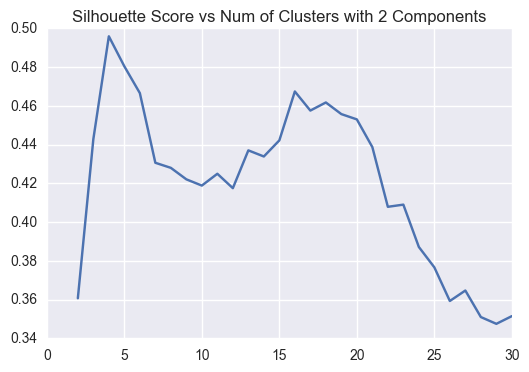

In [65]:
plot_clusters(2, 30, x_back_tfidf)

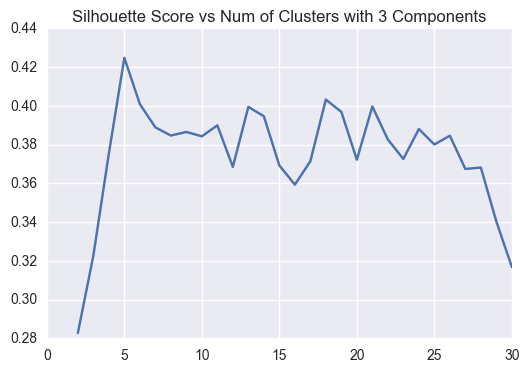

In [66]:
plot_clusters(3, 30, x_back_tfidf)

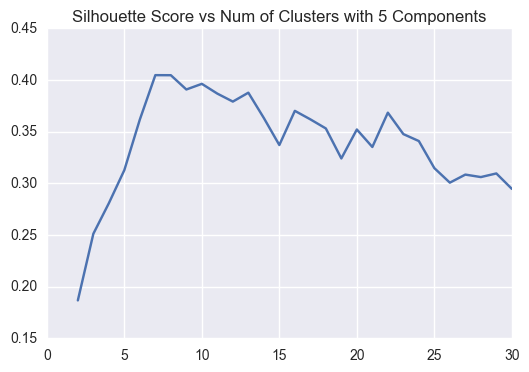

In [67]:
plot_clusters(5, 30, x_back_tfidf)

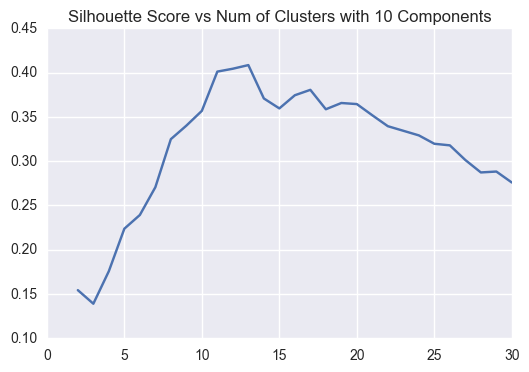

In [68]:
plot_clusters(10, 30, x_back_tfidf)

As you can see, the result from clustering isn't ideal - the silhouette score can't get higher than 0.5. Let's take a look at the data in 3D and see if we can detect any pattern.

### Visualize the Data

In [69]:
# PCA using SVD - 3 components

pca_reducer_3 = PCA(n_components = 3, random_state= 4444)
pca_reduced_X_3 = pca_reducer_3.fit_transform(x_back_tfidf)

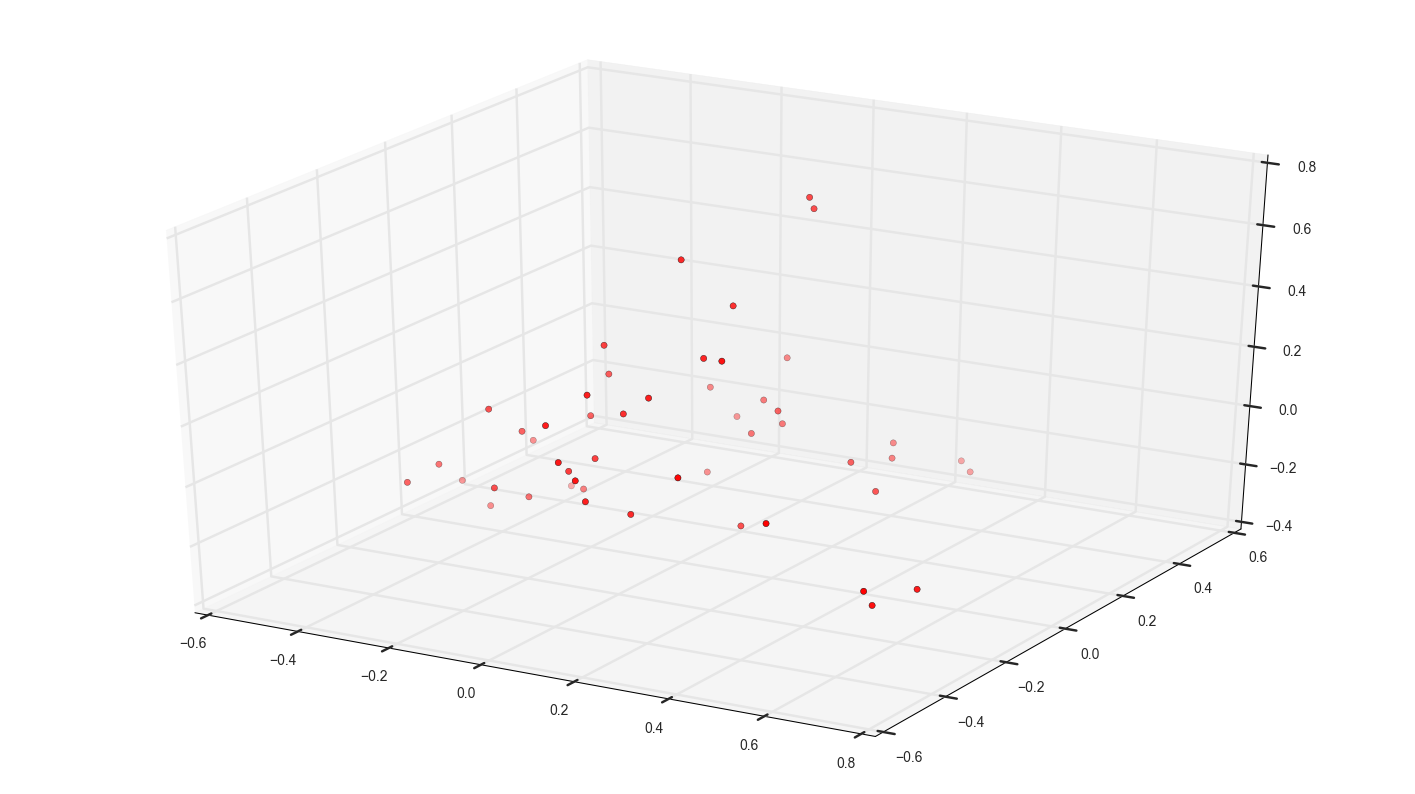

In [136]:
fig = plt.figure(figsize=(18, 10)) 
ax = fig.add_subplot(111, projection='3d')

reduced_df = pd.DataFrame(pca_reduced_X_3)

ax.scatter(reduced_df[0], reduced_df[1], reduced_df[2], c='r')

plt.show()

### Distance Based Recommendation

In [84]:
# Pairwise Euclidean Distance Matrix 

dist_df = pd.DataFrame(pairwise_distances(reduced_df, metric = 'euclidean'), columns=list_of_tags)
dist_df.index = list_of_tags
dist_df = dist_df.round(2)
dist_df.head(10)

,google,viber,snapchat,instagram,facebook,battlefield,windows-10,secret,vine,flipboard,facebook-messenger,dropbox,pebble,airbnb,hoteltonight,y-combinator,twitter,sony,india,"facebook-ipo,facebook",blackberry,adzuna,linkedin,facebookwhatsapp,meetups,zynga,nokia,fleep,"rishi-mandal,sosh",france-newsletter,pinterest,"twitter,vine",foursquare,jack-dorsey,htc,techcrunch,gadgets-podcast,hp,disrupt,iot,iphone,kickstarter,ibm,tesla,nintendo,line,spotify,raspberry-pi,"chet-kanojia,aereo",china
google,0.00,0.38,0.50,0.32,0.70,0.54,0.13,0.21,0.50,0.43,0.74,0.51,0.53,0.34,0.45,0.35,0.30,0.52,0.52,0.73,0.65,0.41,0.52,0.57,0.60,0.35,0.33,0.39,0.35,0.40,0.54,0.50,0.52,0.30,0.65,0.63,0.25,0.69,0.39,0.47,0.60,0.14,0.55,0.29,0.45,0.46,0.12,0.26,0.33,0.69
viber,0.38,0.00,0.33,0.52,0.75,0.59,0.37,0.47,0.81,0.06,0.72,0.21,0.44,0.21,0.24,0.37,0.61,0.31,0.27,0.73,0.41,0.42,0.20,0.49,0.81,0.34,0.44,0.26,0.16,0.33,0.23,0.81,0.19,0.63,0.48,0.83,0.56,0.54,0.50,0.25,0.56,0.44,0.22,0.50,0.34,0.21,0.43,0.46,0.29,0.40
snapchat,0.50,0.33,0.00,0.49,0.55,0.65,0.55,0.51,0.90,0.34,0.48,0.31,0.76,0.52,0.33,0.37,0.69,0.61,0.57,0.51,0.73,0.34,0.21,0.21,0.87,0.38,0.67,0.26,0.29,0.51,0.19,0.89,0.24,0.73,0.79,0.89,0.73,0.86,0.54,0.57,0.87,0.62,0.51,0.74,0.63,0.22,0.59,0.70,0.55,0.70
instagram,0.32,0.52,0.49,0.00,0.42,0.79,0.35,0.12,0.45,0.56,0.50,0.66,0.75,0.59,0.63,0.54,0.25,0.66,0.76,0.47,0.84,0.56,0.56,0.44,0.84,0.26,0.46,0.55,0.53,0.67,0.60,0.42,0.62,0.31,0.79,0.87,0.52,0.87,0.63,0.69,0.76,0.41,0.69,0.51,0.60,0.47,0.34,0.54,0.62,0.86
facebook,0.70,0.75,0.55,0.42,0.00,1.07,0.74,0.53,0.80,0.76,0.15,0.83,1.07,0.90,0.84,0.79,0.65,0.92,1.02,0.10,1.10,0.76,0.66,0.35,1.17,0.48,0.82,0.75,0.77,0.96,0.70,0.76,0.75,0.72,1.06,1.20,0.93,1.16,0.91,0.97,1.08,0.82,0.90,0.91,0.89,0.58,0.75,0.94,0.94,1.08
battlefield,0.54,0.59,0.65,0.79,1.07,0.00,0.63,0.71,0.98,0.64,1.05,0.52,0.77,0.54,0.42,0.29,0.81,0.81,0.58,1.08,0.82,0.33,0.71,0.81,0.31,0.80,0.79,0.41,0.45,0.30,0.66,0.99,0.61,0.80,0.94,0.31,0.56,0.93,0.17,0.63,0.94,0.58,0.75,0.70,0.80,0.73,0.63,0.59,0.42,0.85
windows-10,0.13,0.37,0.55,0.35,0.74,0.63,0.00,0.24,0.46,0.42,0.78,0.54,0.44,0.31,0.50,0.45,0.28,0.44,0.50,0.77,0.57,0.52,0.53,0.63,0.69,0.33,0.20,0.46,0.40,0.44,0.57,0.47,0.54,0.28,0.54,0.72,0.25,0.59,0.49,0.42,0.48,0.11,0.50,0.19,0.35,0.47,0.06,0.20,0.33,0.63
secret,0.21,0.47,0.51,0.12,0.53,0.71,0.24,0.00,0.40,0.52,0.60,0.63,0.66,0.50,0.58,0.49,0.18,0.60,0.68,0.58,0.77,0.52,0.55,0.50,0.75,0.27,0.38,0.51,0.48,0.59,0.59,0.39,0.60,0.23,0.73,0.79,0.40,0.80,0.55,0.61,0.68,0.30,0.64,0.40,0.53,0.47,0.22,0.43,0.52,0.81
vine,0.50,0.81,0.90,0.45,0.80,0.98,0.46,0.40,0.00,0.86,0.91,0.99,0.80,0.76,0.94,0.83,0.22,0.82,0.95,0.87,0.98,0.88,0.92,0.88,0.90,0.60,0.48,0.88,0.84,0.87,0.97,0.05,0.97,0.19,0.87,0.94,0.48,0.92,0.84,0.86,0.73,0.46,0.93,0.45,0.71,0.84,0.41,0.54,0.78,1.04
flipboard,0.43,0.06,0.34,0.56,0.76,0.64,0.42,0.52,0.86,0.00,0.73,0.21,0.45,0.25,0.26,0.41,0.65,0.29,0.27,0.74,0.39,0.46,0.18,0.50,0.86,0.36,0.47,0.30,0.20,0.37,0.21,0.86,0.17,0.68,0.47,0.88,0.61,0.53,0.55,0.25,0.57,0.49,0.18,0.55,0.34,0.20,0.48,0.50,0.33,0.37


In [85]:
# Recommendation Function

def dist_rec(tag):
    dist_df = pd.read_pickle('dist_df.pkl')
    d = dict(dist_df[tag])
    sorted_dist = sorted(d.items(), key=lambda x: x[1])
    return sorted_dist[1], ' ', sorted_dist[2], sorted_dist[3]

In [86]:
# Example recommendation

dist_rec('htc')

(('blackberry', 0.059999999999999998),
 ('nokia', 0.070000000000000007),
 ('iphone', 0.14999999999999999))

In [87]:
# Example recommendation

dist_rec('facebook')

(('facebook-messenger', 0.02),
 ('facebook-ipo,facebook', 0.029999999999999999),
 ('facebookwhatsapp', 0.23999999999999999))

In [88]:
# Example recommendation

dist_rec('twitter')

# Jack Dorsey is the co-founder of Twittera

(('jack-dorsey', 0.029999999999999999),
 ('vine', 0.14000000000000001),
 ('twitter,vine', 0.14999999999999999))

In [89]:
# Example recommendation

dist_rec('dropbox')

# rishi-mandal is the co-founder of sosh, which was acquired by postmate

(('spotify', 0.040000000000000001),
 ('rishi-mandal,sosh', 0.080000000000000002),
 ('foursquare', 0.080000000000000002))

In [90]:
# Example recommendation

dist_rec('tesla')

(('windows-10', 0.13),
 ('flipboard', 0.17999999999999999),
 ('raspberry-pi', 0.20000000000000001))

In [ ]:
dist_rec('tesla')

### Sentiment Analysis with Tags

In [92]:
# Sentiment of articles

def article_sentiment(data):
    d = OrderedDict()
    n = 0
    for item in data:
        name = list_of_tags[n]
        d[name] = TextBlob(item).sentiment[0]
        n += 1
    return d

In [93]:
df_sentiments = article_sentiment(contents)

In [94]:
df_sentiment_sorted = sorted(df_sentiments.items(), key=lambda x: x[1])

In [95]:
# Display the sentiment with each tag in ascending order

df_sentiment_sorted

[('zynga', -0.07949968264817887),
 ('secret', -0.07626923479746028),
 ('line', -0.04438807250688441),
 ('nintendo', -0.03207387193583515),
 ('india', 0.023875037176563915),
 ('nokia', 0.026498685363716027),
 ('blackberry', 0.028194288790735496),
 ('kickstarter', 0.029081526271893234),
 ('iot', 0.03935634087028505),
 ('jack-dorsey', 0.040619145449653914),
 ('viber', 0.042781495715169204),
 ('snapchat', 0.052561355855473474),
 ('facebook-ipo,facebook', 0.05294824234407565),
 ('iphone', 0.05364246702909496),
 ('ibm', 0.05788360881542701),
 ('china', 0.06420558193879089),
 ('spotify', 0.06457814534361764),
 ('adzuna', 0.06610069854388033),
 ('instagram', 0.06823428459350794),
 ('google', 0.07024976205827266),
 ('facebook', 0.0718479537810393),
 ('hoteltonight', 0.07552876792238493),
 ('twitter,vine', 0.0764294459749005),
 ('foursquare', 0.07649710258096336),
 ('sony', 0.07698126784562953),
 ('pinterest', 0.07737920544022912),
 ('raspberry-pi', 0.07947926634768739),
 ('france-newsletter', 0

In [106]:
df_sentiment_neg = df_sentiment_sorted[0:4]
df_sentiment_pos = df_sentiment_sorted[4:]

In [108]:
df_sentiment_pos

[('india', 0.023875037176563915),
 ('nokia', 0.026498685363716027),
 ('blackberry', 0.028194288790735496),
 ('kickstarter', 0.029081526271893234),
 ('iot', 0.03935634087028505),
 ('jack-dorsey', 0.040619145449653914),
 ('viber', 0.042781495715169204),
 ('snapchat', 0.052561355855473474),
 ('facebook-ipo,facebook', 0.05294824234407565),
 ('iphone', 0.05364246702909496),
 ('ibm', 0.05788360881542701),
 ('china', 0.06420558193879089),
 ('spotify', 0.06457814534361764),
 ('adzuna', 0.06610069854388033),
 ('instagram', 0.06823428459350794),
 ('google', 0.07024976205827266),
 ('facebook', 0.0718479537810393),
 ('hoteltonight', 0.07552876792238493),
 ('twitter,vine', 0.0764294459749005),
 ('foursquare', 0.07649710258096336),
 ('sony', 0.07698126784562953),
 ('pinterest', 0.07737920544022912),
 ('raspberry-pi', 0.07947926634768739),
 ('france-newsletter', 0.0795099476201838),
 ('twitter', 0.07962902482133252),
 ('htc', 0.08044925444925446),
 ('dropbox', 0.08137980241222566),
 ('battlefield', 0

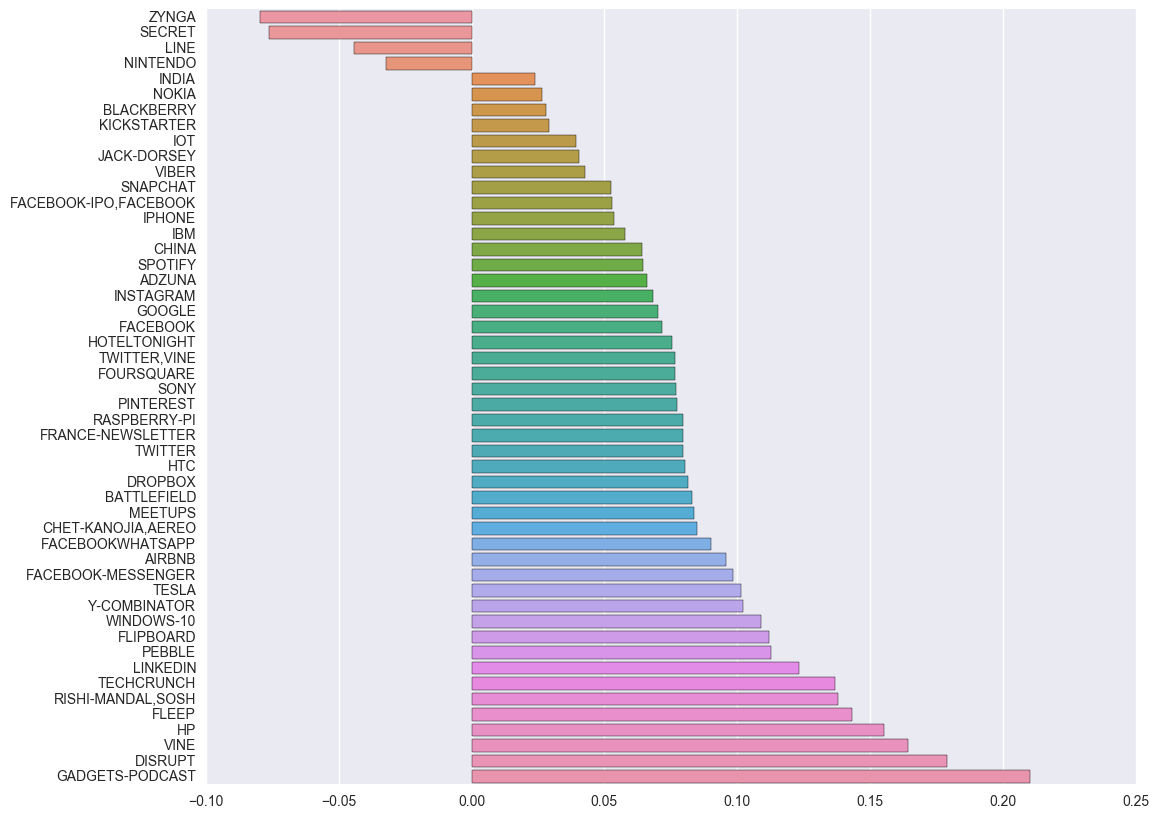

In [96]:
plt.figure(figsize=(12, 10))
sns.barplot(list(zip(*df_sentiment_sorted))[1], [x.upper() for x in list(zip(*df_sentiment_sorted))[0]])
plt.savefig('sentiment.png')

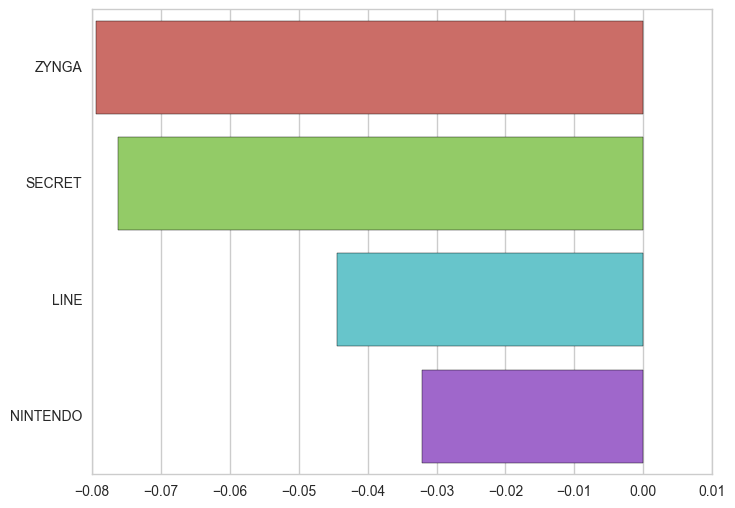

In [132]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(list(zip(*df_sentiment_neg))[1], [x.upper() for x in list(zip(*df_sentiment_neg))[0]], palette = ("hls"))
plt.savefig('sentiment_neg.png', bbox_inches = 'tight')

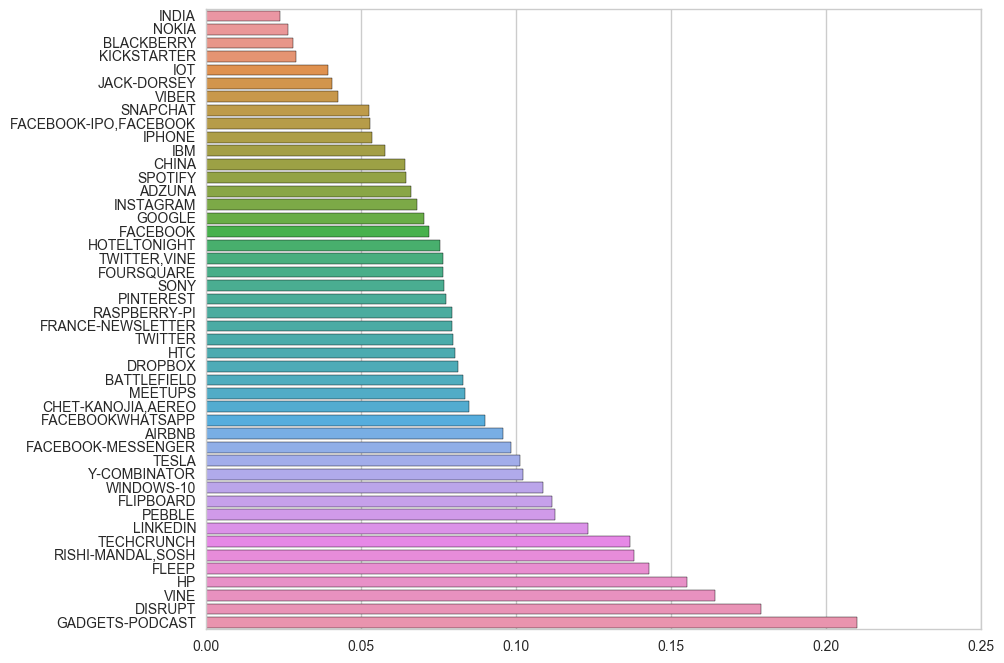

In [131]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(list(zip(*df_sentiment_pos))[1], [x.upper() for x in list(zip(*df_sentiment_pos))[0]])
plt.savefig('sentiment_pos.png', bbox_inches = 'tight')

### Flask Application

In [ ]:
response = requests.post('http://127.0.0.1:5000/rec', json={'rec':'facebook'})

In [ ]:
print (response.json())